<a href="https://colab.research.google.com/github/Amal-Alalami/Projects-CV/blob/main/CNN_ABF%26CLAHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# to generate data
from keras.preprocessing.image import ImageDataGenerator

# to build model
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout
%matplotlib inline

# Upload Dataset

In [3]:
!7z x archive.zip



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 35779075 bytes (35 MiB)

Extracting archive: archive.zip
 64% 4096 Open              --
Path = archive.zip
Type = zip
Physical Size = 35779075

  0%     11% 787 - Alzheimer_s Dataset/test/NonDemented/32 (60).jpg                                                            22% 1543 - Alzheimer_s Dataset/train/MildDemented/mildDem336.jpg                                                                  33% 2179          42% 

# **Pre-processed data and Visualize Sample Images**

In [7]:
# Method to print sample images from each class

def print_sample_images(train_path, class_labels):

  plt.figure(figsize=(10, 10))
  for i, class_name in enumerate(class_labels):

    # Get a random image from the class directory
    img_name = np.random.choice(os.listdir(os.path.join(train_path, class_name)))
    img_path = os.path.join(train_path, class_name, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(4, 4, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

  plt.show()

**Sample of train images before pre-processing data from each class**

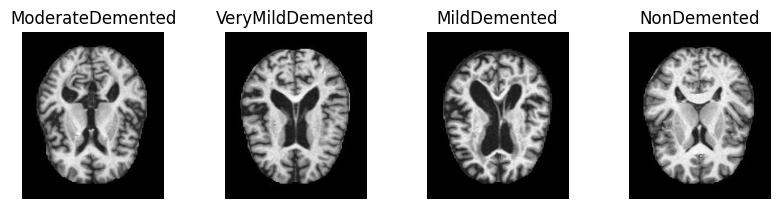

In [47]:
train_dir = '/content/Alzheimer_s Dataset/train'
class_names = os.listdir('/content/Alzheimer_s Dataset/train')
print_sample_images(train_dir, class_names)

**Pre-processing data**

In [4]:
def process_images_in_folder(folder_path):
  image_width, image_height = 128, 128

  for filename in os.listdir(folder_path):
    image_path = os.path.join(folder_path, filename)
    image = cv2.imread(image_path)

    #pre-processing data using ABF (Adaptive Bilateral filter) and Contrast Limited Adaptive Histogram Equalization (CLAHE)

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    bilateral = cv2.bilateralFilter(gray_image, 15, 75, 75)
    clahe = cv2.createCLAHE(clipLimit=2)
    preprocessed_image = clahe.apply(bilateral)

    # Save the pre-processed image with the same filename
    cv2.imwrite(image_path, preprocessed_image)

In [5]:
train_data_path = '/content/Alzheimer_s Dataset/train'
test_data_path = '/content/Alzheimer_s Dataset/test'
class_labels = os.listdir('/content/Alzheimer_s Dataset/train')

# train data
for class_label in class_labels:
  class_folder_path = os.path.join(train_data_path, class_label)
  process_images_in_folder(class_folder_path)

# test data
for class_label in class_labels:
  class_folder_path = os.path.join(test_data_path, class_label)
  process_images_in_folder(class_folder_path)


**Sample of train images after pre-processing data from each class**

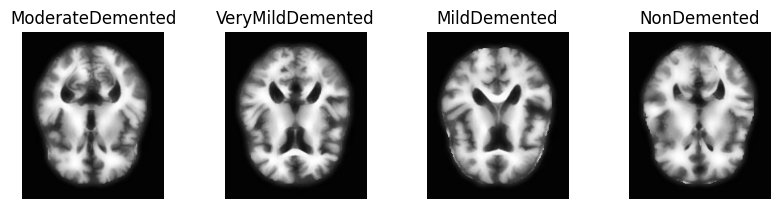

In [8]:
train_dir = '/content/Alzheimer_s Dataset/train'
class_names = os.listdir('/content/Alzheimer_s Dataset/train')
print_sample_images(train_dir, class_names)

In [ ]:
#!shutil.make_archive('AlzheimerDatasetProcessed', 'zip', 'pre-processed_Alzheimer_s Dataset')


# Images in train data & Oversampling

In [9]:
train_folder = '/content/Alzheimer_s Dataset/train'
class_names_train_folder = os.listdir(train_folder)
class_count = []

for class_name in class_names_train_folder:
  num_images = len(os.listdir(os.path.join(train_folder, class_name)))
  class_count.append(num_images)
  print(f"Class {class_name}: {num_images} images")


Class ModerateDemented: 52 images
Class VeryMildDemented: 1792 images
Class MildDemented: 717 images
Class NonDemented: 2560 images


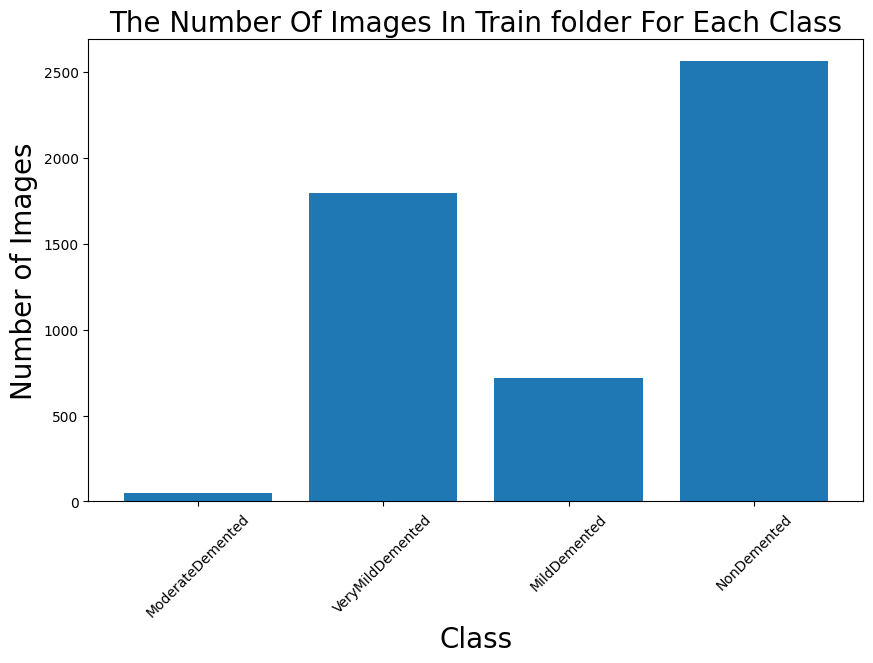

In [10]:

plt.figure(figsize=(10, 6))
plt.bar(class_names_train_folder, class_count)

plt.title('The Number Of Images In Train folder For Each Class', fontsize=20)
plt.xlabel("Class", fontsize = 20)
plt.ylabel("Number of Images", fontsize=20)
plt.xticks(rotation=45)

plt.show()


**Oversampling data**

In [11]:
rotation_angles = [-45, 45, 75]

data_augmentation = ImageDataGenerator(
    rescale = 1/255,
    rotation_range=rotation_angles,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [12]:
train_folder = '/content/Alzheimer_s Dataset/train'
class_names = os.listdir(train_folder)
class_name_to_label = {class_name: i for i, class_name in enumerate(class_names)}
desired_count = 1700
image_width, image_height = 128, 128
augmented_data = []
augmented_labels = []

for class_name in class_names:
    class_folder = os.path.join(train_folder, class_name)
    for angle in rotation_angles:
        class_count = 0

        while class_count < desired_count:
            for image_file in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_file)

                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                image = cv2.resize(image, (image_width, image_height))
                image = image / 255.0 #normalize
                image = image.reshape(1, image_width, image_height, 1)

                label = class_name_to_label[class_name]
                data_augmentation = ImageDataGenerator(rotation_range=angle)

                augmented_images = data_augmentation.flow(image)
                for _ in range(1):
                    augmented_data.append(augmented_images.next().reshape(image_width, image_height, 1))
                    augmented_labels.append(label)

                class_count += 1


print(type(augmented_data))

augmented_data = np.array(augmented_data)
augmented_labels = np.array(augmented_labels)
class_counts = np.bincount(augmented_labels)

for class_name, label in class_name_to_label.items():
    print(f"Class Name: {class_name}, Label: {label}, Count: {class_counts[label]} items")

<class 'list'>
Class Name: ModerateDemented, Label: 0, Count: 5148 items
Class Name: VeryMildDemented, Label: 1, Count: 5376 items
Class Name: MildDemented, Label: 2, Count: 6453 items
Class Name: NonDemented, Label: 3, Count: 7680 items


In [ ]:
'''plt.figure(figsize=(10, 10))
for i,augmented_image in enumerate(augmented_data):
  img = augmented_image * 255
  cv2_imshow(img.reshape(image_width, image_height))'''

#augmented_image = augmented_data[1002] * 255
#cv2_imshow(augmented_image.reshape(image_width, image_height))

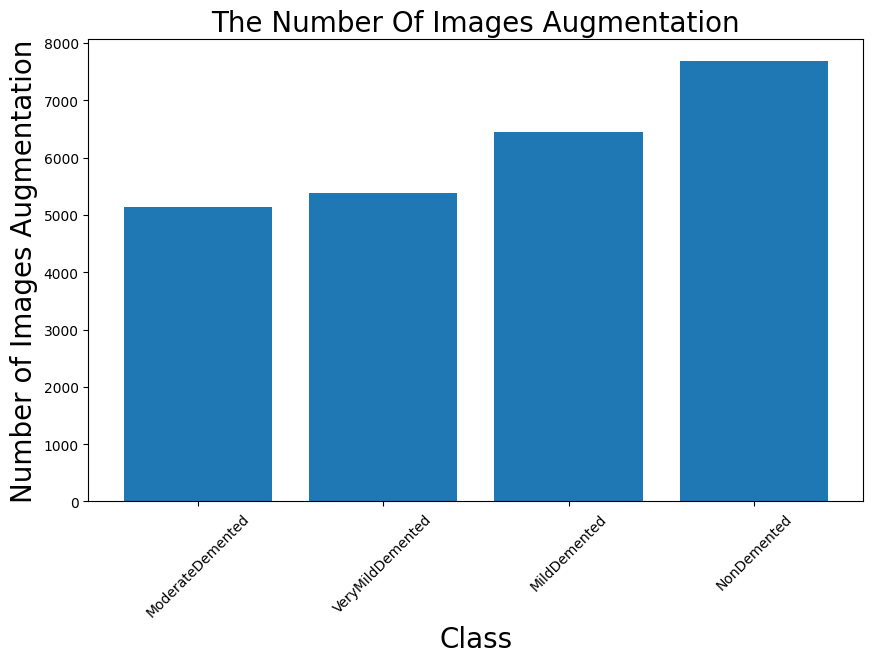

In [13]:
class_count = np.bincount(augmented_labels)
class_label = class_names

plt.figure(figsize=(10, 6))
plt.bar(class_label, class_count)

plt.title('The Number Of Images Augmentation', fontsize=20)
plt.xlabel("Class", fontsize = 20)
plt.ylabel("Number of Images Augmentation", fontsize=20)
plt.xticks(rotation=45)

plt.show()

# **Train Test split and Build Model**

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(augmented_data, augmented_labels, test_size=0.3, random_state=42)

In [15]:
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")

X_train shape: (17259, 128, 128, 1)
Y_train shape: (17259,)


In [16]:
Y_train

array([0, 3, 0, ..., 0, 2, 3])

In [17]:
Y_train = tf.keras.utils.to_categorical(Y_train)

In [18]:
Y_train

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [19]:
# CNN model
model1 = Sequential()
inputSize = (128,128,1)

#ilters=32, kernel_size=(4,4), input_shape=(28,28,1), activation='relu')
model1.add(Conv2D(filters = 32, kernel_size=(3,3), input_shape=inputSize, activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Conv2D(filters = 32, kernel_size=(3,3), input_shape=inputSize, activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Conv2D(filters = 32, kernel_size=(3,3), input_shape=inputSize, activation='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Flatten())

model1.add(Dense(1024, activation='relu'))
model1.add(Dropout(0.2))

model1.add(Dense(4, activation = 'softmax'))
model1.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [20]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0

In [21]:
results = model1.fit(X_train, Y_train, epochs=50)

Epoch 1/50
540/540 [==============================] - 334s 617ms/step - loss: 1.0650 - accuracy: 0.5124
Epoch 2/50
540/540 [==============================] - 333s 616ms/step - loss: 0.7547 - accuracy: 0.6557
Epoch 3/50
540/540 [==============================] - 340s 630ms/step - loss: 0.6481 - accuracy: 0.7028
Epoch 4/50
540/540 [==============================] - 336s 622ms/step - loss: 0.5493 - accuracy: 0.7614
Epoch 5/50
540/540 [==============================] - 344s 638ms/step - loss: 0.4613 - accuracy: 0.8032
Epoch 6/50
540/540 [==============================] - 340s 629ms/step - loss: 0.3663 - accuracy: 0.8474
Epoch 7/50
540/540 [==============================] - 337s 623ms/step - loss: 0.2832 - accuracy: 0.8860
Epoch 8/50
540/540 [==============================] - 334s 619ms/step - loss: 0.2217 - accuracy: 0.9135
Epoch 9/50
540/540 [==============================] - 332s 615ms/step - loss: 0.1668 - accuracy: 0.9360
Epoch 10/50
540/540 [==============================] - 333s 616m

In [22]:
print(model1.output_shape)

(None, 4)


# **Model Evaluation**

In [23]:
Y_test_cat = tf.keras.utils.to_categorical(Y_test)
print(X_test.shape)
print(Y_test_cat.shape)
model1.evaluate(X_test, Y_test_cat)

(7398, 128, 128, 1)
(7398, 4)
232/232 [==============================] - 40s 172ms/step - loss: 0.9761 - accuracy: 0.8486


[0.9760650396347046, 0.8486077189445496]

In [25]:
# Reshape Y_test to a 1-dimensional array
Y_test = Y_test.reshape(-1,)

predictions = model1.predict(X_test)
Y_predected = np.argmax(predictions, axis=1)
y_test_ = np.argmax(Y_test,axis=0)

df = pd.DataFrame({'Actual': Y_test, 'Prediction': Y_predected})
df

232/232 [==============================] - 45s 193ms/step


,Actual,Prediction
0,3,3
1,2,2
2,1,1
3,3,2
4,3,3
...,...,...
7393,3,1
7394,2,2
7395,0,0
7396,2,2


array([[1544,    0,    1,    0],
       [  30, 1045,  208,  346],
       [  13,   76, 1789,   45],
       [  15,  225,  161, 1900]])

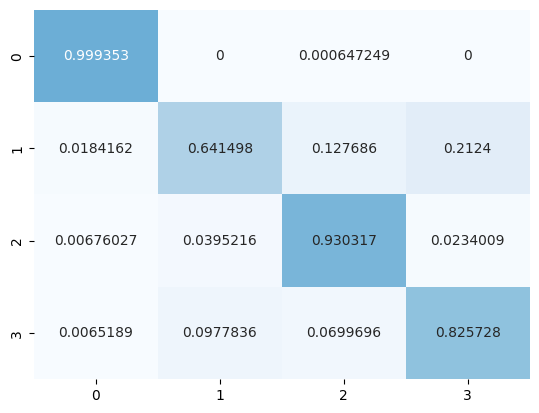

In [30]:
CM = confusion_matrix(Y_test,Y_predected)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]

sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [32]:
print(classification_report(Y_test, Y_predected))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1545
           1       0.78      0.64      0.70      1629
           2       0.83      0.93      0.88      1923
           3       0.83      0.83      0.83      2301

    accuracy                           0.85      7398
   macro avg       0.85      0.85      0.85      7398
weighted avg       0.85      0.85      0.84      7398

